In [102]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams  ## run command settings for plotting
from sklearn.metrics import roc_auc_score, roc_curve

In [103]:
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['SimHei'],
    "font.size": 10,  
    'axes.unicode_minus': False 
}

rcParams.update(config)

In [104]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

计算逻辑回归损失

In [105]:
def computeCost(X,Y,W):
    P=sigmoid(np.dot(X,W))
    loss=np.sum(-Y*np.log(P)-(1-Y)*np.log(1-P))/X.shape[0]
    return loss,P

逻辑回归梯度下降

In [106]:
def gradientDecent(W,X,Y):
   
    error=sigmoid(np.dot(X,W))-Y#P=sigmoid(f(x,w)),P-Y
    
    grad=np.dot(X.T,error)/X.shape[0]#x.shape是样本数
   
    W-=alpha*grad
    return W

In [107]:
def logisticRegression(X,Y,alpha,iters,X1,Y1):    
    feature_dim=X.shape[1]
    W=np.zeros((feature_dim,1))
    loss_his=[]
    loss_v=[]
    for i in range(iters):
        loss,P=computeCost(X,Y,W)
        loss1,P1=computeCost(X1,Y1,W)
        
        loss_his.append(loss)
        loss_v.append(loss1)
        W=gradientDecent(W,X,Y)
                                
    return loss_his,W,loss_v,P

In [108]:
def logisticRegression1(X,Y,alpha,iters):    
    feature_dim=X.shape[1]
    W=np.zeros((feature_dim,1))
    loss_his=[]
    w_his=[]
    for i in range(iters):
        loss,P=computeCost(X,Y,W)
        
        loss_his.append(loss)
        w_his.append(W.copy())
        W=gradientDecent(W,X,Y)
                                
    return loss_his,W,w_his

模型评估

In [109]:
def assess(P,Y):
    
    index = np.argsort(P, axis=0)[::-1]
    P1=np.take_along_axis(P, index, axis=0)
    Y1=np.take_along_axis(Y, index, axis=0)

    # 求PR
    recall = []
    precision = []
    TPR = []
    FPR = []
    F1_score=[]
    for a in P1:
        tp = 0
        fn = 0
        fp = 0
        tn = 0
        x = 0
        y = 0
        for p in range(len(Y1)):
            if (Y1[p] == 1) and (P1[p] >= a):
                tp = tp + 1
            elif (Y1[p] == 1) and (P1[p] < a):
                fn = fn + 1
            elif (Y1[p] == 0) and (P1[p] >= a):
                fp = fp + 1
            elif (Y1[p] == 0) and (P1[p] < a):
                tn = tn + 1
        x = float(tp) / (tp + fn)
        y = float(tp) / (tp + fp)
        fpr = float(fp) / (tn + fp)
        f1_score=(2*float(y)*x)/(x+y)
        
        recall.append(x)
        precision.append(y)
        TPR.append(x)
        FPR.append(fpr)
        F1_score.append(f1_score)

#计算auc，Roc
    y_true = []
    y_score = []
    for p in range(len(Y1)):
        y_c = Y1[p]
        if y_c == 1:
            y = 1
        else:
            y = 0

        y_hat = P[p]
        y_true.append(y)
        y_score.append(y_hat)

    # 计算auc
    auc = roc_auc_score(y_true, y_score, sample_weight=None)
    
    fpr, tpr, th = roc_curve(y_true, y_score)
    return precision,recall,F1_score,fpr,tpr,auc

In [110]:
## 读取数据
import numpy as np
data = np.loadtxt('C:\\Users\\wyp\\Desktop\\ex2data1.txt', delimiter=',')

In [111]:
## K折交叉验证划分数据
from sklearn.model_selection import KFold

total_loss_his=[0]*10000
total_loss_v=[0]*10000

total_W=np.zeros((3,1))

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(data):
    cols = data.shape[1]
    train, test = data[train_index], data[test_index]
  
    X = train[:,:cols-1]
    y=train[:,cols-1:]
    X = np.insert(X, 0, 1, axis=1)   

    X1 = test[:,:cols-1]
    y1=test[:,cols-1:]
    X1 = np.insert(X1, 0, 1, axis=1)  

    
    alpha =0.0001
    iters = 10000
    
    #loss_his, W,loss_v,P = logisticRegression(X,y, alpha, iters,X1,y1)
    loss_his,W,w_his=logisticRegression1(X,y, alpha, iters)

    total_W=total_W+W

   
    v_loss=[]
    for w in w_his:
        loss,_=computeCost(X1,y1,w)
        v_loss.append(loss)
    #获取总的loss
    total_loss_his=list(np.add(loss_his,total_loss_his))
    total_loss_v=list(np.add(v_loss,total_loss_v))
    

total_loss_his=list(np.array(total_loss_his)/5) 
total_loss_v=list(np.array(total_loss_v)/5)
total_W=total_W/5


In [112]:

t_x = data[:,:cols-1]
t_y=data[:,cols-1:]
t_x = np.insert(t_x, 0, 1, axis=1)
loss1,p=computeCost(t_x,t_y,total_W)
precision,recall,F1_score,fpr,tpr,auc=assess(p,t_y)

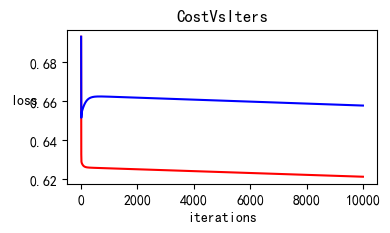

In [113]:
fig,ax=plt.subplots(figsize=(4,2))
ax.plot(np.arange(iters),total_loss_his,'r')
ax.plot(np.arange(iters),total_loss_v,'b')
ax.set_xlabel('iterations')
ax.set_ylabel('loss',rotation=0)
ax.set_title('CostVsIters')
plt.show()

In [114]:
auc

0.4058333333333333

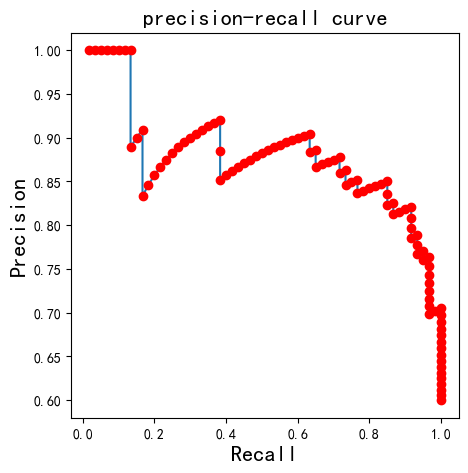

In [115]:
plt.figure(figsize=(5,5))
plt.title('precision-recall curve',fontsize=16)
plt.plot(recall,precision)
plt.plot(recall,precision,'ro')
plt.ylabel('Precision',fontsize=16)
plt.xlabel('Recall',fontsize=16)
plt.show()

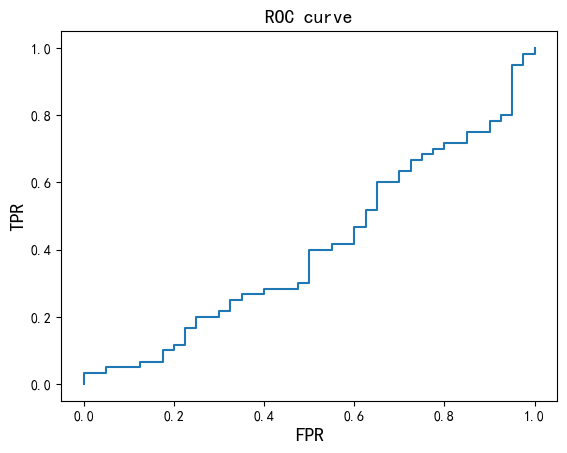

In [116]:
plt.plot(fpr,tpr)
plt.title('ROC curve',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.xlabel('FPR',fontsize=14)
plt.show()